# Automatic vs Finite Differences in Metacalibration

This notebook tests metacalibration by using automatic or finite differentiation, in a realistic CFIS-like galaxy images derived from the COSMOS catalogue.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tqdm

import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf
import galflow as gf
import ngmix

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
batch_size=1000
data= tfds.load('CFIS')
data = data['train'].cache()
data = data.repeat()
data = data.shuffle(1000)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling cfis-train.tfrecord...:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset cfis downloaded and prepared to /local/home/az264973/tensorflow_datasets/cfis/parametric_1k/0.5.0. Subsequent calls will reuse this data.


In [4]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
gal_images = onebatch['gal_model'] 
labels = onebatch['label'] 
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin='lower')
  title(f"g1= {labels[i][0]:.4f},g2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

KeyError: 'gal_model'

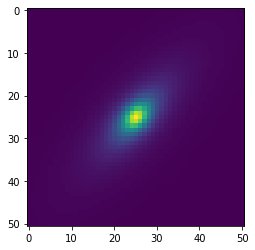

In [9]:
imshow(onebatch['obs'][0])

In [5]:
sheared=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                          tf.repeat([[0.,0.05]],len(onebatch['gal_model']),axis=0))

noise_level = 1e-6
noise = np.random.normal(scale=noise_level,size=[1000,51,51])
sheared += noise

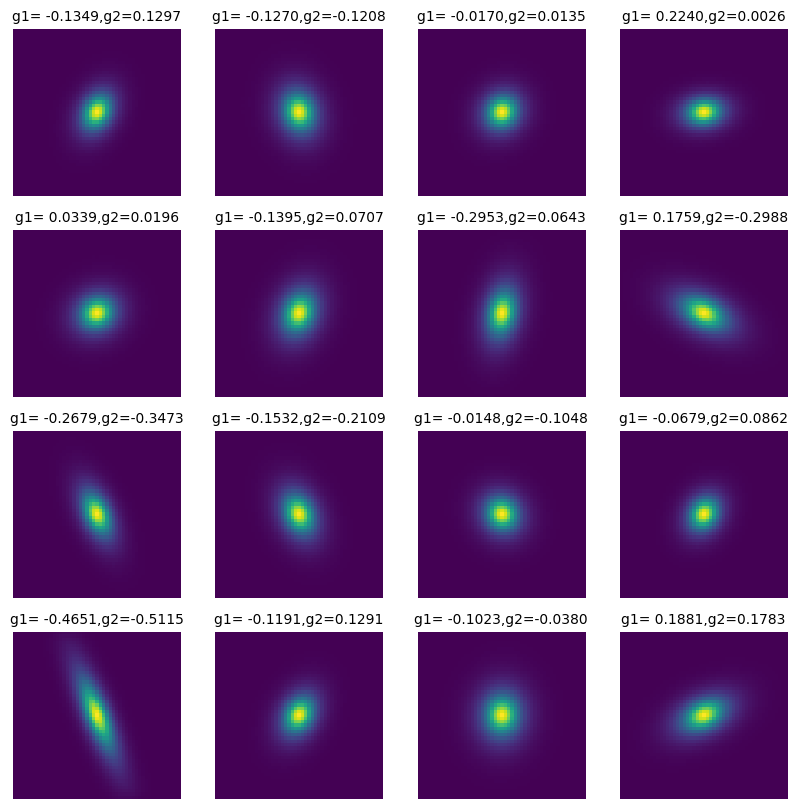

In [6]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(sheared[i],origin= 'lower')
  title(f"g1= {labels[i][0]:.4f},g2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

In [7]:
im = sheared[0]
psf_im = onebatch['psf_image'][0] 

In [8]:
scale= .2
stamp_size = 51

jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)
psf_jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)

In [9]:
wt = tf.reduce_mean(1.0/(noise)**2,axis=0)
psf_wt = tf.reduce_mean(1.0/(noise/100)**2,axis=0)

psf_obs = ngmix.Observation(
  psf_im,
  weight=psf_wt,
  jacobian=psf_jacobian,
)
obs = ngmix.Observation(
  im,
  jacobian=jacobian,
  weight=wt,
  psf=psf_obs,
)

In [10]:
rng = np.random.RandomState(31415)

# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both 
# psf and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent

types = ['noshear', '1p', '1m','2p','2m']
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='gauss',
  types=types,
  fixnoise=True,
)

In [11]:
resdict, obsdict = boot.go(obs)

In [12]:
def get_metacal_response_ngmix(resdict):
  step=0.01
  types = ['noshear', '1p', '1m','2p','2m']
  e1, e2 = resdict['noshear']['e1'], resdict['noshear']['e2']
 
  g0s = np.array([resdict['noshear']['e1'], resdict['noshear']['e2']])
  g1p = np.array([resdict['1p']['e1'], resdict['1p']['e2']])
  g1m = np.array([resdict['1m']['e1'], resdict['1m']['e2']])
  g2p = np.array([resdict['2p']['e1'], resdict['2p']['e2']])
  g2m = np.array([resdict['2m']['e1'], resdict['2m']['e2']])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)  
   
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])
    
  return ellip_dict, R  

## Shakedown Test!

In [13]:
true = labels[0]
#ngmix calibration
ellips, R_ngmix = get_metacal_response_ngmix(resdict)
calibrated_ngmix = linalg.inv(R_ngmix) @ ellips['noshear']
#AutoMetaCal run
method = lambda im: amc.get_moment_ellipticities(im, scale=0.2, fwhm=1.2)
R_auto = amc.get_metacal_response(im[tf.newaxis], psf_im[tf.newaxis],psf_im[tf.newaxis],method)
e_amc=method(im[tf.newaxis])
calibrated_amc = linalg.inv(R_auto[1][0].numpy()) @ e_amc[0].numpy()

In [14]:
print("True:")
print(f"e1={true[0]:.6f}, e2={true[1]:.6f}.")

print("\nngmix:")
print(f"e1={calibrated_ngmix[0]:.6f}, e2={calibrated_ngmix[1]:.6f}.")

print("\nAutoMetaCal")
print(f"e1={calibrated_amc[0]:.6f}, e2={calibrated_amc[1]:.6f}.")

True:
e1=-0.134935, e2=0.129653.

ngmix:
e1=-0.138429, e2=0.186786.

AutoMetaCal
e1=-0.138443, e2=0.186821.


## One Batch Test

In [15]:
batch_size=1000
data= tfds.load('GalGen/small_stamp_1k')
data = data['train'].cache()
data = data.repeat()
data = data.shuffle(1000)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
real_shear = [0.01,0.0]
import galsim

psf_fwhm = 0.7
reconv_psf = galsim.Moffat(beta=5.0, 
                    fwhm=psf_fwhm*1.4)
reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(reconv_psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)


reconv_psf_image = obs.psf.image.reshape(1,51,51).astype('float32') 
method = lambda im: amc.get_moment_ellipticities(im, scale=0.2, fwhm=1.2)

In [17]:
batchit = data.as_numpy_iterator()

In [18]:
@tf.function
def response(gal_images,psf_images):
  return amc.get_metacal_response(gal_images, psf_images,psf_images,method)

In [19]:
e_amc = []
R_auto = []

onebatch = batchit.next()

sheared=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                          tf.repeat([real_shear],len(onebatch['gal_model']),axis=0))

noise = np.random.normal(scale=noise_level,size=[len(sheared),51,51])
sheared += noise

gal_images = sheared
psf_images = onebatch['psf_image']
e_amc_batch, R_auto_batch = response(gal_images, psf_images)
e_amc.append(e_amc_batch)
R_auto.append(R_auto_batch)
  
e_amc=tf.concat(e_amc,axis=0)
R_auto=tf.concat(R_auto,axis=0)

In [20]:
uncalibrated_shear_amc = tf.reduce_mean(e_amc,axis=0)
calibrated_shear_amc = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.reduce_mean(tf.reshape(e_amc,[-1,2,1]),axis=0)
calibrated_shear_amc_err = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.math.reduce_std(tf.reshape(e_amc,[-1,2,1]),axis=0)/sqrt(batch_size)

In [21]:
%%timeit
e_amc_batch, R_auto_batch = response(gal_images, psf_images)

4.79 s ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Perform the same test with ngmix:

In [22]:
rng = np.random.RandomState(31415)

# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both 
# psf and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent

types = ['noshear', '1p', '1m','2p','2m']
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='gauss',
  types=types,
  fixnoise=True,
)

In [23]:
sheared=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                          tf.repeat([real_shear],len(onebatch['gal_model']),axis=0))

noise = np.random.normal(scale=noise_level,size=[len(sheared),51,51])
sheared += noise

gal_images = sheared
psf_images = onebatch['psf_image']

In [24]:
def response_ngmix(im_psf):
  im, psf = im_psf
  
  psf_obs = ngmix.Observation(
    psf_im,
    weight=psf_wt,
    jacobian=psf_jacobian,
  )
  obs = ngmix.Observation(
    im,
    jacobian=jacobian,
    weight=wt,
    psf=psf_obs,
  )
  
  #get moment ellipticities
  resdict, obsdict = boot.go(obs)
  e_ngmix, R_ngmix = get_metacal_response_ngmix(resdict)
  
  return e_ngmix['noshear'], R_ngmix

In [25]:
%%timeit
response_ngmix((gal_images[0],psf_images[0]))

87.8 ms ± 450 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


To be fair, let's use ngmix in parallel. 

In [26]:
from multiprocessing import Pool, freeze_support, cpu_count
pool = Pool(cpu_count()) 

In [27]:
gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
psf_imlist = [psf_images[i] for i in range(len(gal_images))]
ims_psfs = zip(gal_imlist,psf_imlist)

In [28]:
t = time.time()
results = pool.map(response_ngmix, ims_psfs)
print(f"Finished in: {time.time()-t} s.")

Finished in: 4.990292549133301 s.


In [29]:
pool.close()

In [30]:
e_ngmix_list = [result[0] for result in results]
R_ngmix_list = [result[1] for result in results]

In [31]:
calibrated_shear_ngmix = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ mean(array(e_ngmix_list),axis=0)
calibrated_shear_ngmix_err = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ std(array(e_ngmix_list),axis=0)/sqrt(batch_size)

In [32]:
linalg.inv(mean(array(R_ngmix_list),axis=0)) @std(array(e_ngmix_list),axis=0)/sqrt(batch_size)

array([0.00755818, 0.00792424])

In [33]:
print("True:")
print(f"e1={real_shear[0]:.6f}, e2={real_shear[1]:.6f}.")

print("\nUncalibrated shear estimation over 1k")
print(f"e1={uncalibrated_shear_amc[0]:.6f}, e2={uncalibrated_shear_amc[1]:.6f}.")

print("\nAutoMetaCal shear estimation over 1k")
print(f"e1={calibrated_shear_amc[0,0]:.6f}, e2={calibrated_shear_amc[1,0]:.6f}.")

print("\nngmix shear estimation over 1k")
print(f"e1={calibrated_shear_ngmix[0]:.6f}, e2={calibrated_shear_ngmix[1]:.6f}.")

True:
e1=0.010000, e2=0.000000.

Uncalibrated shear estimation over 1k
e1=0.003230, e2=-0.008789.

AutoMetaCal shear estimation over 1k
e1=0.007121, e2=-0.019938.

ngmix shear estimation over 1k
e1=0.007136, e2=-0.019936.


In [34]:
m1_amc =  calibrated_shear_amc[0,0]/real_shear[0] - 1 
m1_amc_err =  calibrated_shear_amc_err[0,0]/real_shear[0]
print("Autometacal:")
print(f"m_1 = {m1_amc: .6f} +/- {m1_amc_err: .6f}")

m1_ngmix =  calibrated_shear_ngmix[0]/real_shear[0] -1 
m1_ngmix_err =  calibrated_shear_ngmix_err[0]/real_shear[0] 
print("\nngmix:")
print(f"m_1 = {m1_ngmix: .6f} +/- {m1_ngmix_err: .6f}")

Autometacal:
m_1 = -0.287925 +/-  0.755756

ngmix:
m_1 = -0.286449 +/-  0.755818


## All Batches Test

In [35]:
batch_size=1000
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.repeat()
data = data.shuffle(1000)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [36]:
batchit = data.as_numpy_iterator()

In [ ]:
e_amc = []
R_auto = []


for _ in tqdm.tqdm(range(100)):
  onebatch = batchit.next()

  sheared=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                            tf.repeat([real_shear],len(onebatch['gal_model']),axis=0))

  noise = np.random.normal(scale=noise_level,size=[len(sheared),51,51])
  sheared += noise

  gal_images = sheared
  psf_images = onebatch['psf_image']

  e_amc_batch, R_auto_batch = response(gal_images, psf_images)
  
  e_amc.append(e_amc_batch)
  R_auto.append(R_auto_batch)
  
e_amc=tf.concat(e_amc,axis=0)
R_auto=tf.concat(R_auto,axis=0)

 47%|████▋     | 47/100 [04:53<05:29,  6.22s/it]

In [ ]:
uncalibrated_shear_amc = tf.reduce_mean(e_amc,axis=0)
calibrated_shear_amc = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.reduce_mean(tf.reshape(e_amc,[-1,2,1]),axis=0)
calibrated_shear_amc_err = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.math.reduce_std(tf.reshape(e_amc,[-1,2,1]),axis=0)/sqrt(batch_size*100)

In [ ]:
print("True:")
print(f"e1={real_shear[0]:.6f}, e2={real_shear[1]:.6f}.")

print("\nUncalibrated shear estimation over 1k")
print(f"e1={uncalibrated_shear_amc[0]:.6f}, e2={uncalibrated_shear_amc[1]:.6f}.")

print("\nAutoMetaCal shear estimation over 1k")
print(f"e1={calibrated_shear_amc[0,0]:.6f}, e2={calibrated_shear_amc[1,0]:.6f}.")

m1_amc =  calibrated_shear_amc[0,0]/real_shear[0] -1 
m1_amc_err =  calibrated_shear_amc_err[0,0]/real_shear[0]

print("\nAutometacal:")
print(f"m_1 = {m1_amc: .6f} +/- {m1_amc_err: .6f}")

Do the same with ngmix:

In [ ]:
batchit = data.as_numpy_iterator()

In [ ]:
e_ngmix_list = []
R_ngmix_list = []
for batchno in tqdm.tqdm(range(100)):
  onebatch = batchit.next()

  sheared=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                            tf.repeat([real_shear],len(onebatch['gal_model']),axis=0))

  noise = np.random.normal(scale=noise_level,size=[len(sheared),51,51])
  sheared += noise

  gal_images = sheared
  psf_images = onebatch['psf_image']
  gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
  psf_imlist = [psf_images[i] for i in range(len(gal_images))]
  ims_psfs = zip(gal_imlist,psf_imlist)
  
  pool = Pool(cpu_count()//2)
  results = pool.map(response_ngmix, ims_psfs)
  pool.close()
  
  e_ngmix_list += [result[0] for result in results]
  R_ngmix_list += [result[1] for result in results]  

In [ ]:
calibrated_shear_ngmix = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ mean(array(e_ngmix_list),axis=0)
calibrated_shear_ngmix_err = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ std(array(e_ngmix_list),axis=0)/sqrt(batch_size*100)

In [ ]:
print("True:")
print(f"e1={real_shear[0]:.6f}, e2={real_shear[1]:.6f}.")

print("\nUncalibrated shear estimation over 1k")
print(f"e1={uncalibrated_shear_amc[0]:.6f}, e2={uncalibrated_shear_amc[1]:.6f}.")

print("\nAutoMetaCal shear estimation over 1k")
print(f"e1={calibrated_shear_amc[0,0]:.6f}, e2={calibrated_shear_amc[1,0]:.6f}.")

print("\nngmix shear estimation over 1k")
print(f"e1={calibrated_shear_ngmix[0]:.6f}, e2={calibrated_shear_ngmix[1]:.6f}.")

In [ ]:
m1_amc =  calibrated_shear_amc[0,0]/real_shear[0] -1 
m1_amc_err = calibrated_shear_amc_err[0,0]/real_shear[0]

print("Autometacal:")
print(f"m_1 = {m1_amc: .6f} +/- {m1_amc_err: .6f}")

m1_ngmix =  calibrated_shear_ngmix[0]/real_shear[0] -1 
m1_ngmix_err = calibrated_shear_ngmix_err[0]/real_shear[0]
print("\nngmix:")
print(f"m_1 = {m1_ngmix: .6f} +/- {m1_ngmix_err: .6f}")